In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.layers import Dense, Flatten, Dropout, ZeroPadding3D
from keras.layers.recurrent import LSTM
from keras.models import Sequential, load_model
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import TimeDistributed
from keras.layers.convolutional import (Conv2D, MaxPooling3D, Conv3D,
    MaxPooling2D)
from collections import deque
import sys

In [2]:
def display_test_scores(test, pred):
    str_out = ""
    str_out += ("TEST SCORES\n")
    str_out += ("\n")

    #print accuracy
    accuracy = accuracy_score(test, pred)
    str_out += ("ACCURACY: {:.4f}\n".format(accuracy))
    str_out += ("\n")

    #print AUC score
    auc = roc_auc_score(test, pred)
    str_out += ("AUC: {:.4f}\n".format(auc))
    str_out += ("\n")

    #print confusion matrix
    str_out += ("CONFUSION MATRIX:\n")
    conf_mat = confusion_matrix(test, pred)
    str_out += ("{}".format(conf_mat))
    str_out += ("\n")
    str_out += ("\n")

    #print FP, FN
    str_out += ("FALSE POSITIVES:\n")
    fp = conf_mat[1][0]
    pos_labels = conf_mat[1][0]+conf_mat[1][1]
    str_out += ("{} out of {} positive labels ({:.4f}%)\n".format(fp, pos_labels,fp/pos_labels))
    str_out += ("\n")

    str_out += ("FALSE NEGATIVES:\n")
    fn = conf_mat[0][1]
    neg_labels = conf_mat[0][1]+conf_mat[0][0]
    str_out += ("{} out of {} negative labels ({:.4f}%)\n".format(fn, neg_labels, fn/neg_labels))
    str_out += ("\n")

    #print classification report
    str_out += ("PRECISION, RECALL, F1 scores:\n")
    str_out += ("{}".format(classification_report(test, pred)))
    
    false_indexes = np.where(test != pred)
    return str_out, false_indexes

In [3]:
################ scaled dataset ###################
df_original2 = pd.read_pickle('../input/ddd-final-datasets/final_step2_scaled.pkl')

In [4]:
################ not-scaled dataset ###################
df_original = pd.read_pickle('../input/ddd-final-datasets/final_step2.pkl')

In [5]:
video_info_df = df_original.iloc[:,0:4]

In [6]:
video_info_df

,subject,external_factors,facial_actions,frame_no
0,004,glasses,mix,3
1,004,glasses,mix,4
2,004,glasses,mix,5
3,004,glasses,mix,6
4,004,glasses,mix,7
...,...,...,...,...
614588,036,noglasses,yawning,1961
614589,036,noglasses,yawning,1962
614590,036,noglasses,yawning,1963
614591,036,noglasses,yawning,1964


In [7]:
df_original2 = pd.concat([video_info_df, df_original2], axis=1)

In [8]:
g = df_original2.groupby(["subject", "external_factors", "facial_actions"])
len(g.groups.keys())

train_list = []
test_list = []

for key in g.groups.keys():
    print(key)
    if key[0] in ['004', '022', '026', '030']:
        test_list.append(g.get_group(key))
    else:
        train_list.append(g.get_group(key))


('001', 'glasses', 'nonsleepyCombination')
('001', 'glasses', 'sleepyCombination')
('001', 'glasses', 'slowBlinkWithNodding')
('001', 'glasses', 'yawning')
('001', 'night_noglasses', 'nonsleepyCombination')
('001', 'night_noglasses', 'sleepyCombination')
('001', 'night_noglasses', 'slowBlinkWithNodding')
('001', 'night_noglasses', 'yawning')
('001', 'nightglasses', 'nonsleepyCombination')
('001', 'nightglasses', 'sleepyCombination')
('001', 'nightglasses', 'slowBlinkWithNodding')
('001', 'nightglasses', 'yawning')
('001', 'noglasses', 'nonsleepyCombination')
('001', 'noglasses', 'sleepyCombination')
('001', 'noglasses', 'slowBlinkWithNodding')
('001', 'noglasses', 'yawning')
('002', 'glasses', 'nonsleepyCombination')
('002', 'glasses', 'sleepyCombination')
('002', 'glasses', 'slowBlinkWithNodding')
('002', 'glasses', 'yawning')
('002', 'night_noglasses', 'nonsleepyCombination')
('002', 'night_noglasses', 'sleepyCombination')
('002', 'night_noglasses', 'slowBlinkWithNodding')
('002', 'n

In [9]:
import os
import sys
scriptpath = "../input/feriha/"

# Add the directory containing your module to the Python path (wants absolute paths)
sys.path.append(os.path.abspath(scriptpath))

In [10]:
df = test_list[0]
df = df.iloc[:, 4:12]
df = pd.concat([df]*4, axis=1)
df_arr = np.repeat(df.values,32,axis=0)
df_arr=np.reshape(df_arr, (-1, 32, 32, 1))

In [11]:
!pip install imutils
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")
# import the necessary packages
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os


# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
image_path="../input/deneme-resimler/deneme"
imagePaths = list(paths.list_images(image_path))
data = []

# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename, load the image, and
    # resize it to be a fixed 64x64 pixels, ignoring aspect ratio

    image = cv2.imread(imagePath)
    #image = cv2.resize(image, (64, 64))
    # update the data and labels lists, respectively
    data.append(image)

  Created wheel for imutils: filename=imutils-0.5.3-py3-none-any.whl size=25850 sha256=2cc1fd6652898041cdd2f496dbe0bd28c93b28400abb7b7075515e3ac07b35b0
  Stored in directory: /root/.cache/pip/wheels/fc/9c/6d/1826267c72afa51b564c9c6e0f66abc806879338bc593a2270
Successfully built imutils
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
[INFO] loading images...


In [12]:
max_h=0
max_w=0
for image in data:
    h,w,c = image.shape
    if h>max_h:
        max_h=h
    if w>max_w:
        max_w=w
        
print("max h:", max_h, "max_w:", max_w)

max h: 198 max_w: 143


In [13]:
padded_list=[]
for image in data:
    h,w,c = image.shape
    x=np.zeros((max_h,max_w,3),dtype=int)*255
    x[:h,:w,:]=image
    padded_list.append(x)

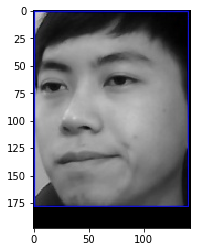

In [14]:
%matplotlib inline 
plt.imshow(padded_list[0], interpolation='nearest')
plt.show()

In [15]:
padded_arr=np.array(padded_list)
padded_arr.shape

(733, 198, 143, 3)

In [16]:
import numpy as np
import argparse
#import i3d_inception
from i3d_inception import Inception_Inflated3d

def evaluate(images):
    NUM_FRAMES,FRAME_HEIGHT,FRAME_WIDTH,NUM_RGB_CHANNELS = images.shape
    NUM_CLASSES = 2

    rgb_model = Inception_Inflated3d(
                    include_top=True, endpoint_logit=False,
                    weights=None,
                    input_shape=(NUM_FRAMES, FRAME_HEIGHT, FRAME_WIDTH, NUM_RGB_CHANNELS),
        classes=NUM_CLASSES)
    
    # make prediction
    rgb_pred = rgb_model.predict(df_arr)
    
    return rgb_pred

In [17]:
evaluate(padded_arr)

ValueError: Negative dimension size caused by subtracting 7 from 5 for '{{node global_avg_pool/AvgPool3D}} = AvgPool3D[T=DT_FLOAT, data_format="NDHWC", ksize=[1, 2, 7, 7, 1], padding="VALID", strides=[1, 1, 1, 1, 1]](Mixed_5c/concat)' with input shapes: [?,92,7,5,1024].

In [18]:
for video in test_list:
    #evaluate(video)
    

SyntaxError: unexpected EOF while parsing (<ipython-input-18-8d2f8acd3c5c>, line 3)